In [1]:
from google.colab import files
  
uploaded = files.upload()

Saving train.csv to train.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv('train.csv')
display(df.head())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df.shape

(913000, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')
df["month"]= parts[1].astype('int')
df["day"]= parts[2].astype('int')
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [9]:
from datetime import datetime
import calendar
      
def weekend_or_weekday(year,month,day):
      
    d = datetime(year,month,day)
    if d.weekday()>4:
        return 1
    else:
        return 0
  
df['weekend'] = df.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1


In [10]:
from datetime import date
import holidays
  
def is_holiday(x):
    
  india_holidays = holidays.country_holidays('IN')
  
  if india_holidays.get(x):
    return 1
  else:
    return 0
  
df['holidays'] = df['date'].apply(is_holiday)
df.head()

,date,store,item,sales,year,month,day,weekend,holidays
0,2013-01-01,1,1,13,2013,1,1,0,0
1,2013-01-02,1,1,11,2013,1,2,0,0
2,2013-01-03,1,1,14,2013,1,3,0,0
3,2013-01-04,1,1,13,2013,1,4,0,0
4,2013-01-05,1,1,10,2013,1,5,1,0


In [11]:
def which_day(year, month, day):
      
    d = datetime(year,month,day)
    return d.weekday()
  
df['weekday'] = df.apply(lambda x: which_day(x['year'],
                                                      x['month'],
                                                      x['day']),
                                   axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0,1
1,2013-01-02,1,1,11,2013,1,2,0,0,2
2,2013-01-03,1,1,14,2013,1,3,0,0,3
3,2013-01-04,1,1,13,2013,1,4,0,0,4
4,2013-01-05,1,1,10,2013,1,5,1,0,5


In [12]:
df.drop('date', axis=1, inplace=True)

In [13]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

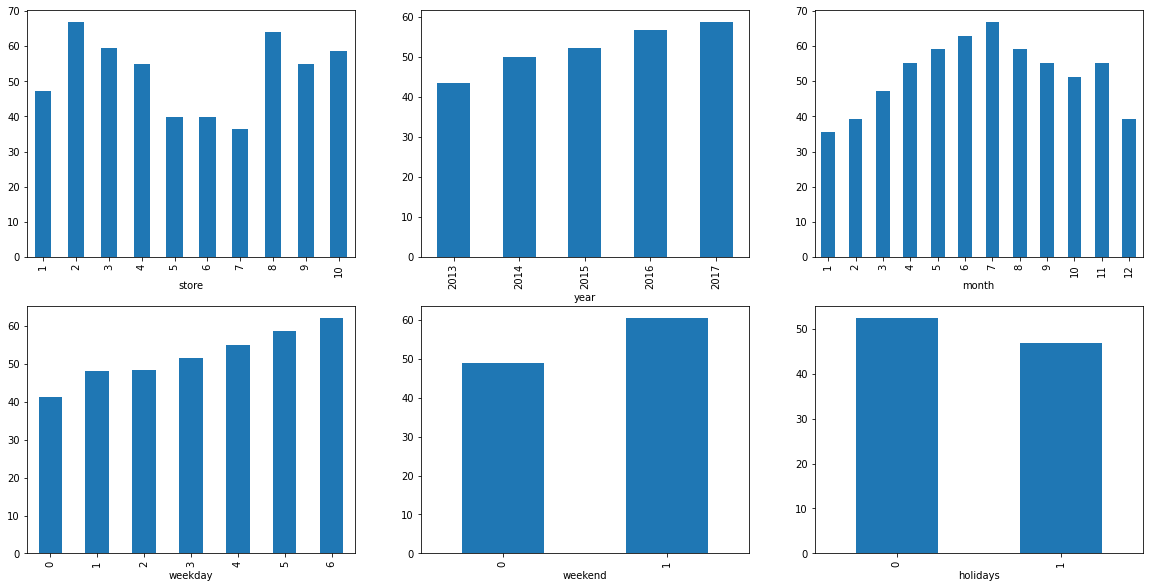

In [14]:
features = ['store', 'year', 'month',\
            'weekday', 'weekend', 'holidays']
  
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    df.groupby(col).mean()['sales'].plot.bar()
plt.show()

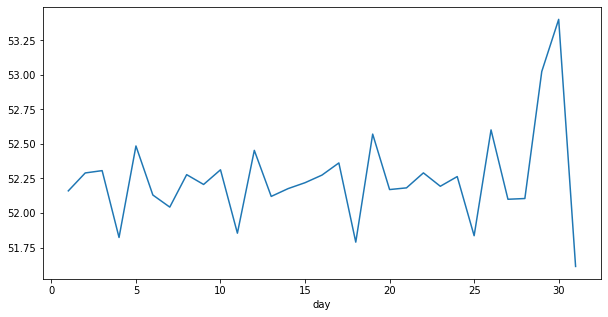

In [15]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()

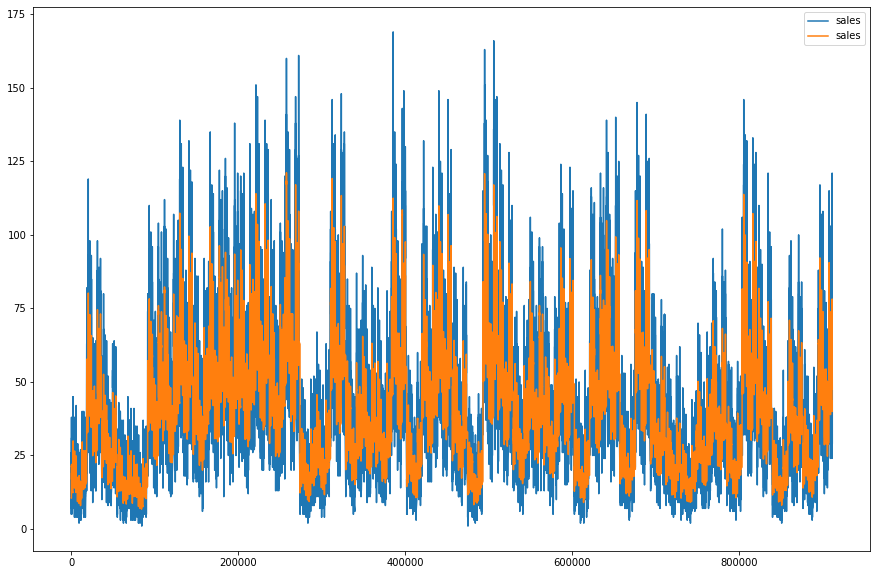

In [16]:
plt.figure(figsize=(15, 10))
  
# Calculating Simple Moving Average 
# for a window period of 30 days
window_size = 30
data = df[df['year']==2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]
  
data['sales'].plot()
sma.plot()
plt.legend()
plt.show()

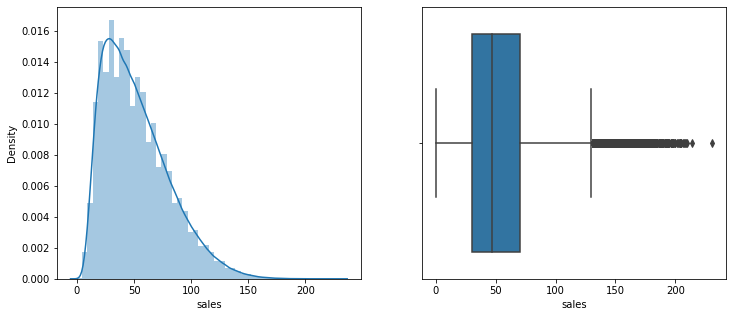

In [17]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])
  
plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()

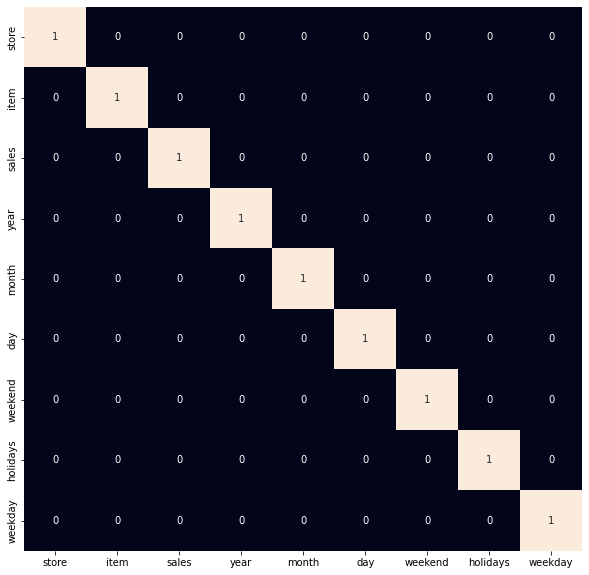

In [18]:
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

In [19]:
df = df[df['sales']<140]

In [20]:
features = df.drop(['sales', 'year'], axis=1)
target = df['sales'].values
  
  
X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                                  test_size = 0.05,
                                                  random_state=22)
X_train.shape, X_val.shape

((861170, 7), (45325, 7))

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [22]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]
  
for i in range(4):
    models[i].fit(X_train, Y_train)
  
    print(f'{models[i]} : ')
  
    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))
  
    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()

LinearRegression() : 
Training Error :  21.858411358092592
Validation Error :  21.93929107349014

[06:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor() : 
Training Error :  11.777996511202334
Validation Error :  11.819466312404371

Lasso() : 
Training Error :  21.950762863498134
Validation Error :  22.01576219213394

Ridge() : 
Training Error :  21.858411480810265
Validation Error :  21.939291195285776

